In [10]:
import numpy as np
import cv2
import pywt
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# Feature Engineering

In [8]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

E:\academic_apps\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(


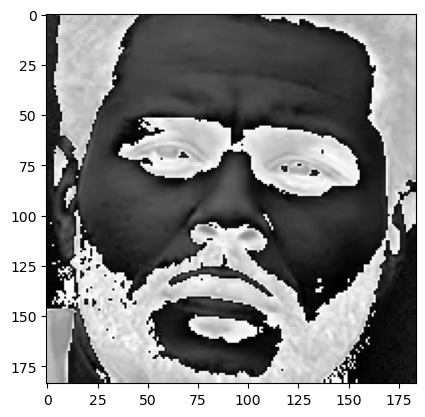

In [95]:
img = cv2.imread('./dataset/cropped/the weeknd/the weeknd24.png')
im_har = w2d(img,'db1',10)
plt.imshow(im_har, cmap='gray')

In [19]:
import os
path_to_cr_data = "./dataset/cropped/"
path_list = []
for entry in os.scandir(path_to_cr_data):
    if entry.is_dir():
        path_list.append(entry.path)
path_list

['./dataset/cropped/drake',
 './dataset/cropped/justin bieber',
 './dataset/cropped/taylor swift',
 './dataset/cropped/the weeknd']

In [13]:
class_dict = {}
count = 0
for path in path_list:
    class_dict[path.split('/')[-1]] = count
    count += 1

In [14]:
class_dict

{'drake': 0, 'justin bieber': 1, 'taylor swift': 2, 'the weeknd': 3}

In [6]:
celebrity_file_names_dict = {}

for folder in path_list:
    celebrity_name = folder.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for img in os.scandir(folder):
        celebrity_file_names_dict[celebrity_name].append(img.path)

In [7]:
celebrity_file_names_dict

{'drake': ['./dataset/cropped/drake\\drake1.png',
  './dataset/cropped/drake\\drake10.png',
  './dataset/cropped/drake\\drake11.png',
  './dataset/cropped/drake\\drake14.png',
  './dataset/cropped/drake\\drake15.png',
  './dataset/cropped/drake\\drake16.png',
  './dataset/cropped/drake\\drake17.png',
  './dataset/cropped/drake\\drake18.png',
  './dataset/cropped/drake\\drake19.png',
  './dataset/cropped/drake\\drake2.png',
  './dataset/cropped/drake\\drake20.png',
  './dataset/cropped/drake\\drake22.png',
  './dataset/cropped/drake\\drake23.png',
  './dataset/cropped/drake\\drake24.png',
  './dataset/cropped/drake\\drake25.png',
  './dataset/cropped/drake\\drake26.png',
  './dataset/cropped/drake\\drake27.png',
  './dataset/cropped/drake\\drake28.png',
  './dataset/cropped/drake\\drake29.png',
  './dataset/cropped/drake\\drake3.png',
  './dataset/cropped/drake\\drake30.png',
  './dataset/cropped/drake\\drake31.png',
  './dataset/cropped/drake\\drake32.png',
  './dataset/cropped/drake\\

In [71]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [72]:
X = np.array(X).reshape(len(X),4096).astype(float)

In [73]:
X

array([[  0.,   0.,   0., ..., 254., 253.,  12.],
       [ 71.,  66.,  54., ..., 246., 254.,   5.],
       [ 49.,  39.,  29., ..., 254., 254., 254.],
       ...,
       [ 64.,  93., 140., ...,  20.,  32.,  25.],
       [ 30.,  28.,  52., ..., 239., 235., 128.],
       [ 18.,  20.,  21., ..., 244., 206.,  23.]])

# Building the model

In [74]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import classification_report

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.75

In [76]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.50      0.67      0.57         9
           2       0.86      0.71      0.77        17
           3       1.00      0.67      0.80        12

    accuracy                           0.75        48
   macro avg       0.77      0.76      0.74        48
weighted avg       0.80      0.75      0.75        48



# hyperparameter tuning

In [77]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [78]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10,20]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [79]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.817488,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.776355,{'randomforestclassifier__n_estimators': 20}
2,logistic_regression,0.817980,{'logisticregression__C': 1}


In [80]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=20))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [81]:
best_estimators['svm'].score(X_test,y_test)

0.7708333333333334

In [82]:
best_estimators['random_forest'].score(X_test,y_test)

0.7083333333333334

In [83]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7916666666666666

In [84]:
best_clf = best_estimators['logistic_regression']

In [85]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[10,  0,  0,  0],
       [ 1,  6,  1,  1],
       [ 1,  3, 13,  0],
       [ 2,  1,  0,  9]], dtype=int64)

Text(58.222222222222214, 0.5, 'Truth')

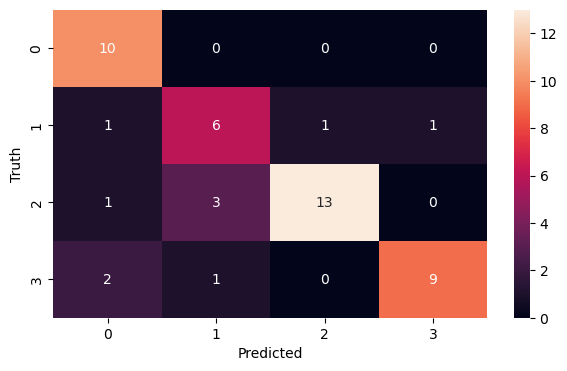

In [86]:
import seaborn as sns
plt.figure(figsize = (7,4))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [87]:
print(classification_report(y_test, best_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.60      0.67      0.63         9
           2       0.93      0.76      0.84        17
           3       0.90      0.75      0.82        12

    accuracy                           0.79        48
   macro avg       0.79      0.80      0.78        48
weighted avg       0.82      0.79      0.79        48

